# Playground for benchmark data and plotting

In [7]:
# import external dependencies
import pandas as pd
import seaborn as sb
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from picasso import folder_selection
from lib.stats import Vmstat, Mpstat, CpuIO, DiskIO, DockerStats, Tootbench, Ping
import lib.filter as filter
import lib.window as window


In [2]:
sb.set_style("whitegrid")
sb.set_context("talk")
#sb.set_palette(sb.crayons)

In [3]:
folders = folder_selection()
folder = folders[0]
folder


Available folders to analyze:
[0]	input/2023-02-07T05:34:39_6core-6GB_25sidekiq_5.5s_interval_20min
[1]	input/2023-02-07T04:01:41
[2]	input/2023-02-07T03:03:10
[3]	input/2023-02-07T00:57:06
[4]	input/2023-02-06T23:52:24
[5]	input/2023-02-06T22:55:23
[6]	input/2023-02-06T03:50:22_10min_25sidekiqthreads_e2-custom-6-6GB_5.5s-interval
[7]	input/2023-02-06T00:11:55_10min_25sidekiqthreads_e2-custom-6-6GB_5.5s-interval
[8]	input/2023-02-05T21:00:37_concurrentClientSetup_10min_25sidekiqthreads_e2-highcpu-4_2.5s-interval
[9]	input/2023-02-04T21:45:36_30min_5reps_remote_follow
[10]	input/2023-02-04T04:07:37_30min_5reps_remote_follow
[11]	input/2023-02-02_18:49:31_5-repeats_10+30users
[12]	input/2023-02-02T15:19:18
[13]	input/2023-02-02T04:28:19
[14]	input/2023-02-02T00:29:24
[15]	input/2023-02-02T00:12:04
[16]	input/2023-02-01T19:08:12
[17]	input/2023-02-01T18:37:40
[18]	input/2023-01-30T22:49:05
[19]	input/2023-01-30T21:55:38


PosixPath('input/2023-02-07T05:34:39_6core-6GB_25sidekiq_5.5s_interval_20min')

In [4]:
vm = Vmstat(folder, False)
mp = Mpstat(folder, False)
dio = DiskIO(folder, False)
#docker = DockerStats(folder, False)
io = CpuIO(folder, False)
ping = Ping(folder,False)
#toot = Tootbench(folder, False)

initializing vmstat
initialized. vmstat
initializing mpstat
initialized. mpstat
initializing iostat-disk
initialized. iostat-disk
initializing iostat-cpu
initialized. iostat-cpu
initializing ping
initialized. ping


In [5]:
print(vm.df["time"])

15757       0.0
20553       0.0
17356       0.0
18955       0.0
15758       1.0
          ...  
30149    1598.0
30150    1599.0
33348    1599.0
31749    1599.0
34947    1599.0
Name: time, Length: 111551, dtype: float64


In [8]:
print(window.tumble([])(vm.df))

/home/stendler/Uni/22 WS/cloudservicebenchmarking/mastodon-fediverse-benchmark/analysis/lib/window.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ret_df = ret_df.groupby(by=[pd.Grouper(key=time_column, freq=freq)] + columns, as_index=False).mean()


KeyError: 'time'

showing new plot: vmstat-cpu-utilization_mastodon


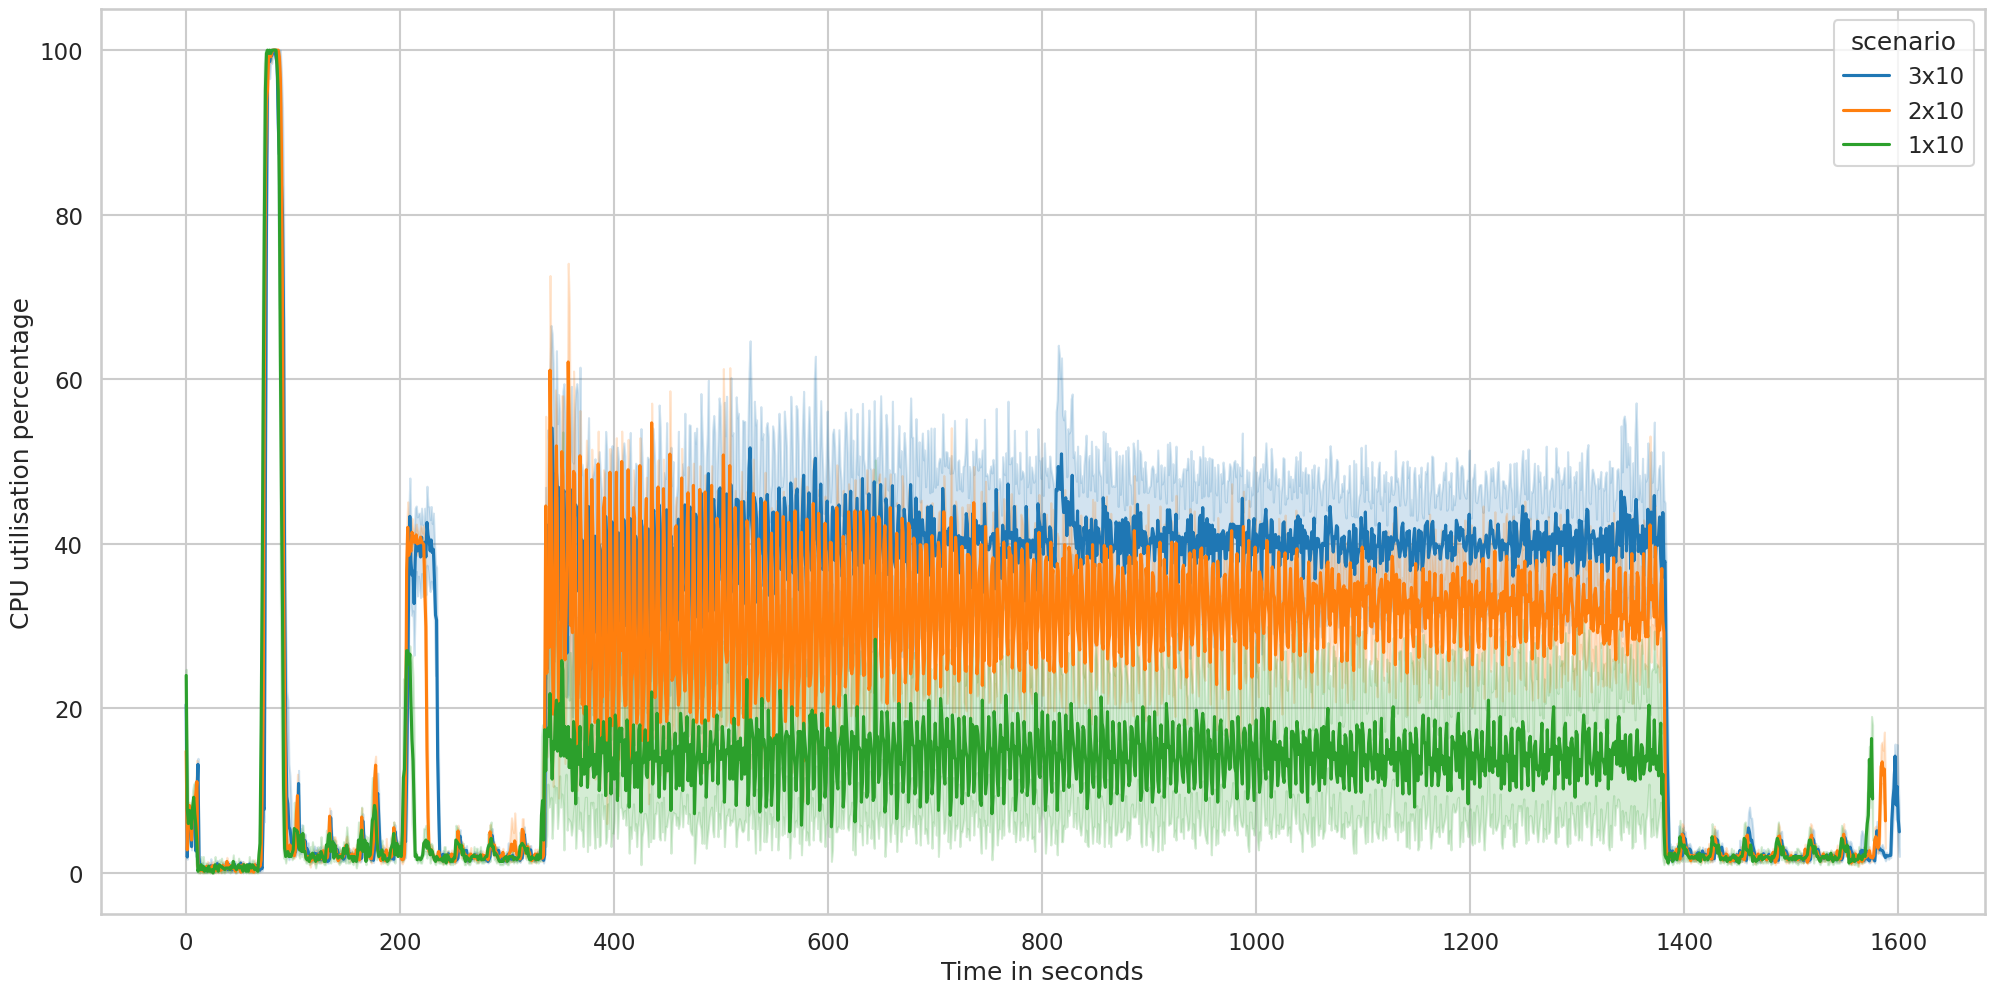

showing new plot: vmstat-kernel-utilization_mastodon


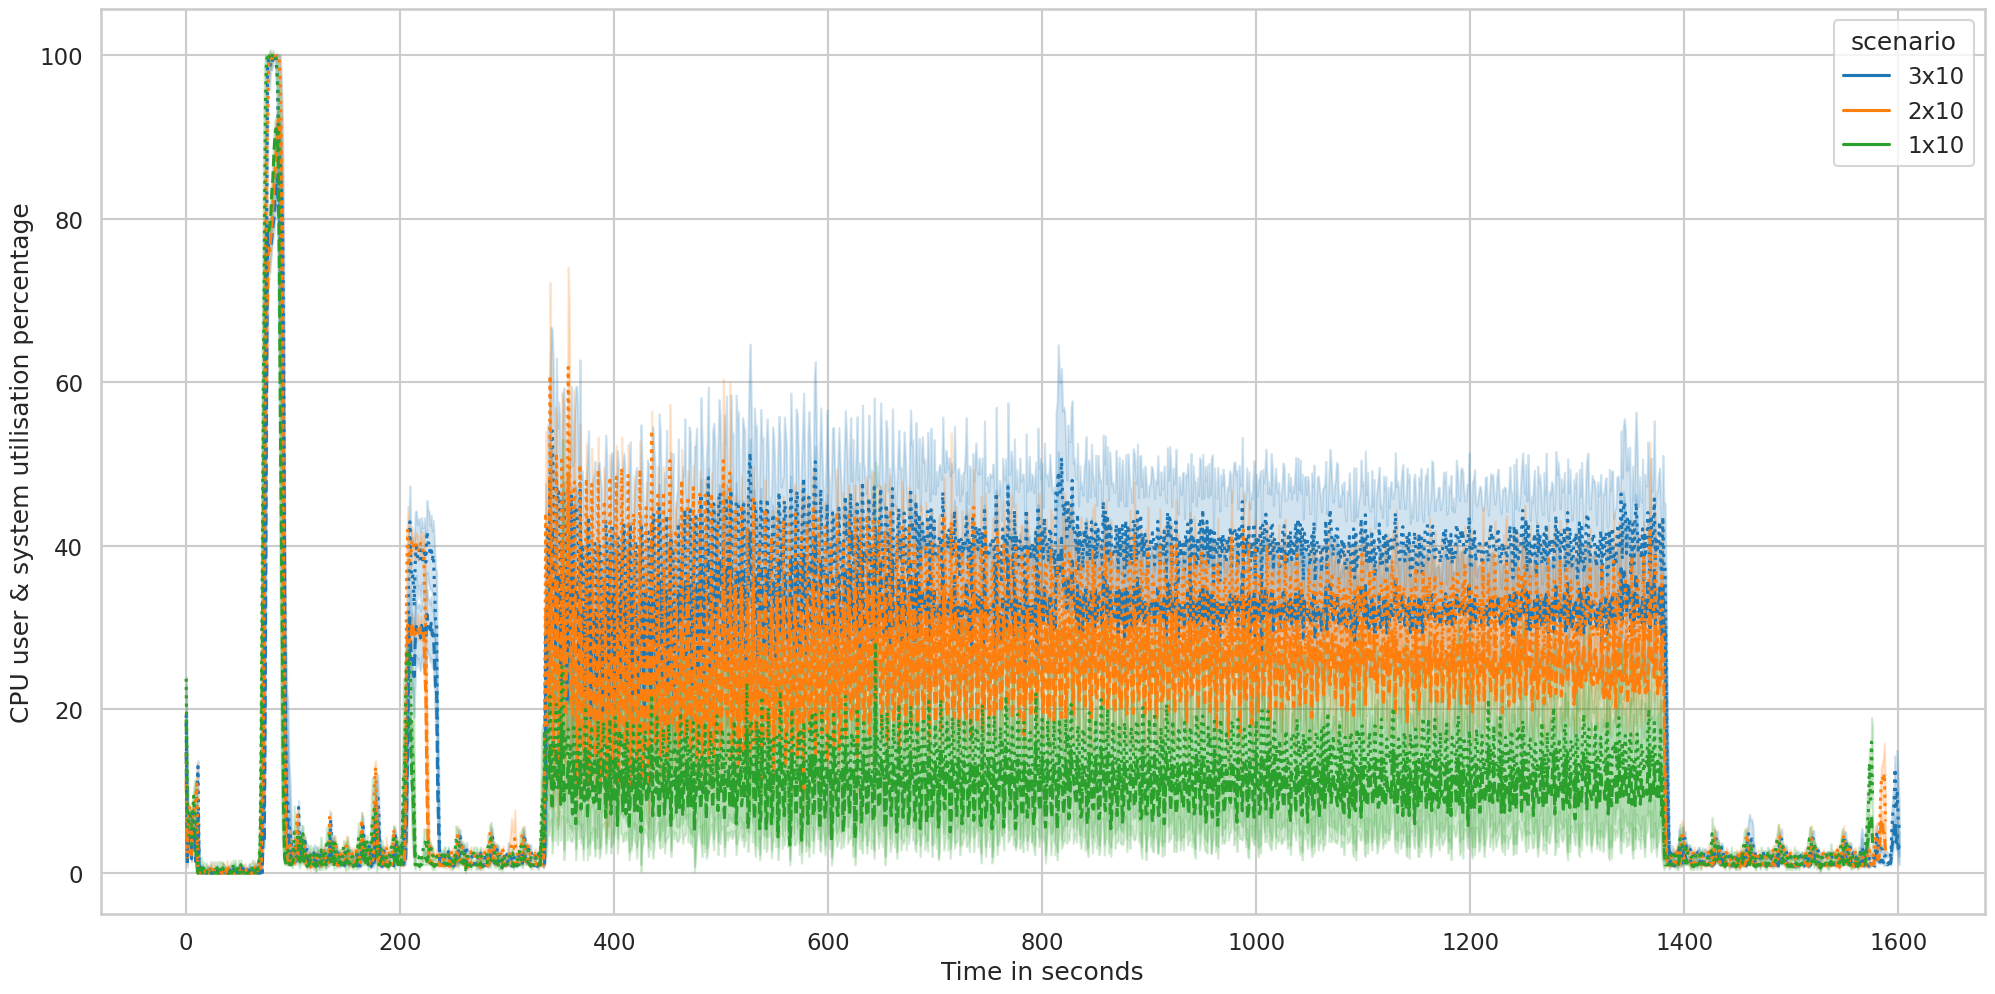

AttributeError: module 'pandas' has no attribute 'timedelta64'

In [ ]:
vm.cpu_utilization(filter.of(filter.instances, filter.either("scenario", "1x10", "2x10", "3x10"), window.tumble([], "time", "s")))

In [57]:
toot = pd.read_csv(folder.joinpath("tootbench.log.gz"), names=["scenario","run","timestamp_iso","message_type","message_len", "sender_username","message_timestamp","server_timestamp","receiver_username", "sender_domain"], header=0)
toot["timestamp_iso"] = pd.to_datetime(toot["timestamp_iso"], utc=True)  # log timestamp
# timestamp of message creation/reception
toot["message_timestamp"] = pd.to_datetime(toot["message_timestamp"], utc=True)
toot["server_timestamp"] = pd.to_datetime(toot["server_timestamp"], utc=True)
# post: delta between message sent and server receive; status: delta between server receive and client receive
toot["delta_tx"] = ((toot["server_timestamp"] - toot["message_timestamp"]) / np.timedelta64(1, 'ms')).astype(np.float64).abs()
# post: delta between server receive and ack to sender; status: delta between server receive and client receive (should be about the same as delta_tx for status)
toot["delta_txack"] = ((toot["timestamp_iso"] - toot["server_timestamp"]) / np.timedelta64(1, 'ms')).astype(np.float64)
#toot.loc[:, "time_delta"] = toot["timestamp_iso"] - toot[["scenario", "run", "timestamp_iso"]].groupby(by=["scenario", "run"], as_index=False).min()["timestamp_iso"]
toot_lowest = toot[["scenario", "run", "timestamp_iso"]].groupby(by=["scenario", "run"]).min()
for i, group in toot.groupby(by=["scenario", "run"]):
  toot.loc[group.index, 'time_delta'] = (group["timestamp_iso"] - toot_lowest.loc[i, "timestamp_iso"]) #/ np.timedelta64(1, 'm'))#.astype(np.float64)


/tmp/ipykernel_4165982/2950590075.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  toot.loc[group.index, 'time_delta'] = (group["timestamp_iso"] - toot_lowest.loc[i, "timestamp_iso"]) #/ np.timedelta64(1, 'm'))#.astype(np.float64)


In [49]:
print(toot["delta_tx"])

0        -368.592292
1         103.570042
2        -675.101931
3       -1005.132316
4       -1016.221388
            ...     
71995    -433.143372
71996    -437.158541
71997    -437.988411
71998    -440.584630
71999    -446.568419
Name: delta_tx, Length: 72000, dtype: float64


In [59]:
print(toot["time_delta"])

0              0 days 00:00:00
1       0 days 00:00:00.207000
2       0 days 00:00:00.306000
3       0 days 00:00:00.466000
4       0 days 00:00:00.477000
                 ...          
71995   0 days 00:28:00.894000
71996   0 days 00:28:00.898000
71997   0 days 00:28:00.898000
71998   0 days 00:28:00.901000
71999   0 days 00:28:00.907000
Name: time_delta, Length: 72000, dtype: timedelta64[ns]


In [25]:
print(toot["sender_domain"])

0        debug-0.europe-west1-b.c.cloud-service-benchma...
1                                                      NaN
2        debug-0.europe-west1-b.c.cloud-service-benchma...
3        debug-0.europe-west1-b.c.cloud-service-benchma...
4        debug-0.europe-west1-b.c.cloud-service-benchma...
                               ...                        
71995    debug-0.europe-west1-b.c.cloud-service-benchma...
71996    debug-0.europe-west1-b.c.cloud-service-benchma...
71997    debug-0.europe-west1-b.c.cloud-service-benchma...
71998    debug-0.europe-west1-b.c.cloud-service-benchma...
71999    debug-0.europe-west1-b.c.cloud-service-benchma...
Name: sender_domain, Length: 72000, dtype: object


<AxesSubplot: xlabel='Time in minutes', ylabel='Message post tx latency in ms'>

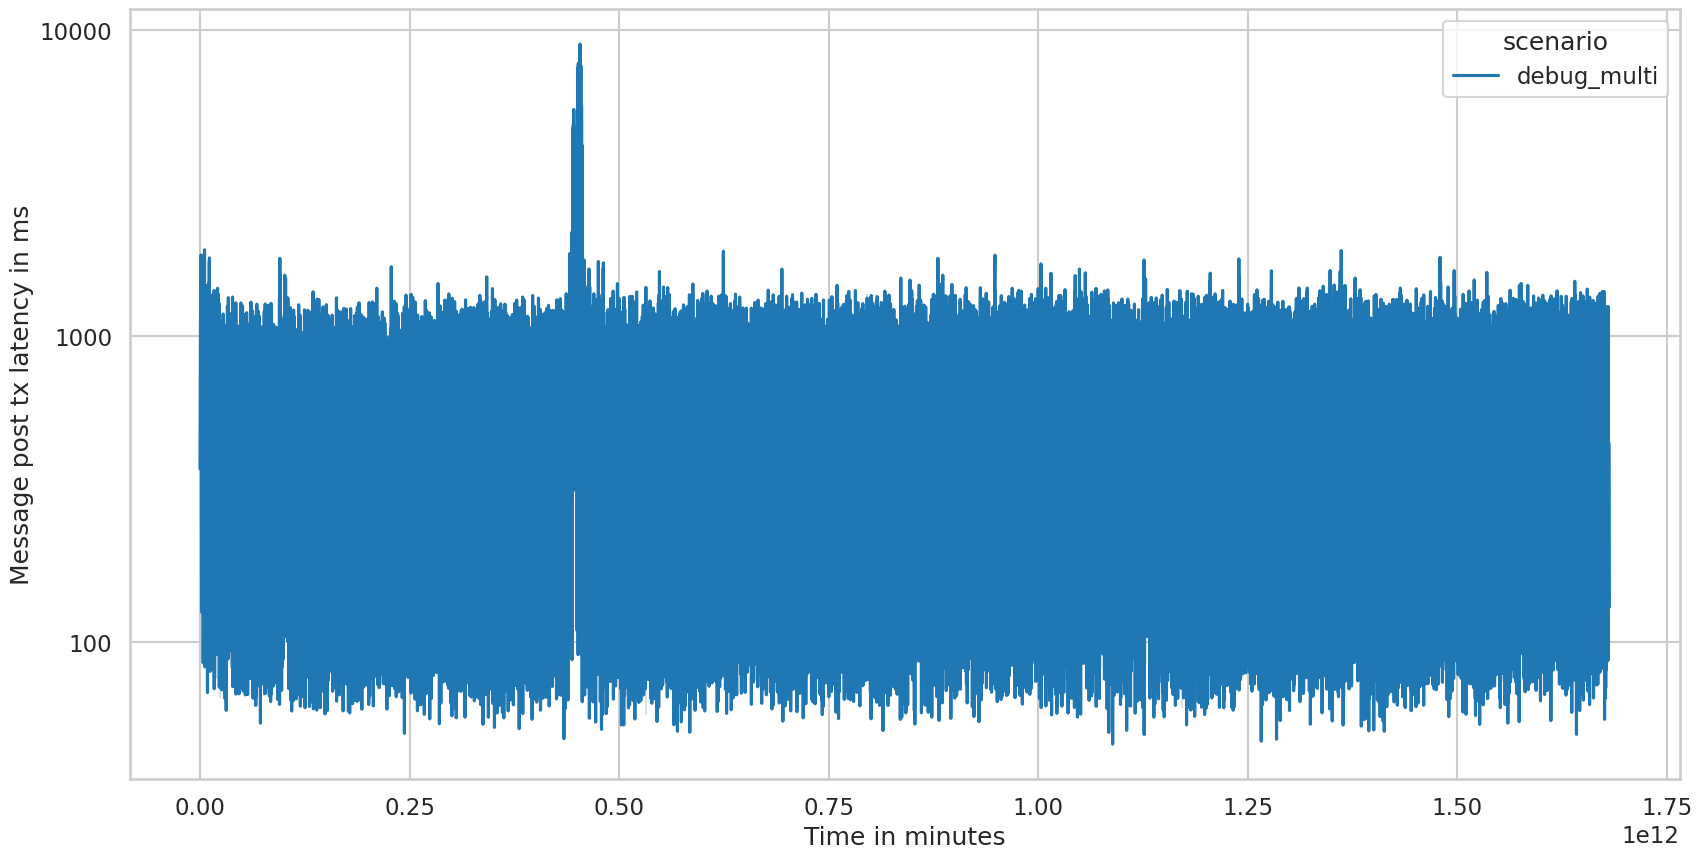

In [61]:
df = toot.loc[toot["message_type"] == "status"]
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in minutes")
ax.set_ylabel("Message post tx latency in ms")
ax.set_yscale("log", base=10)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sb.lineplot(x="time_delta", y="delta_tx", hue="scenario", data=df, ax=ax)

In [64]:
help(df.groupby(by=["scenario", "run", pd.Grouper(key="time_delta", freq="5s")]))

pandas.core.groupby.generic.DataFrameGroupBy

<AxesSubplot: xlabel='Time in minutes', ylabel='Message post tx latency in ms'>

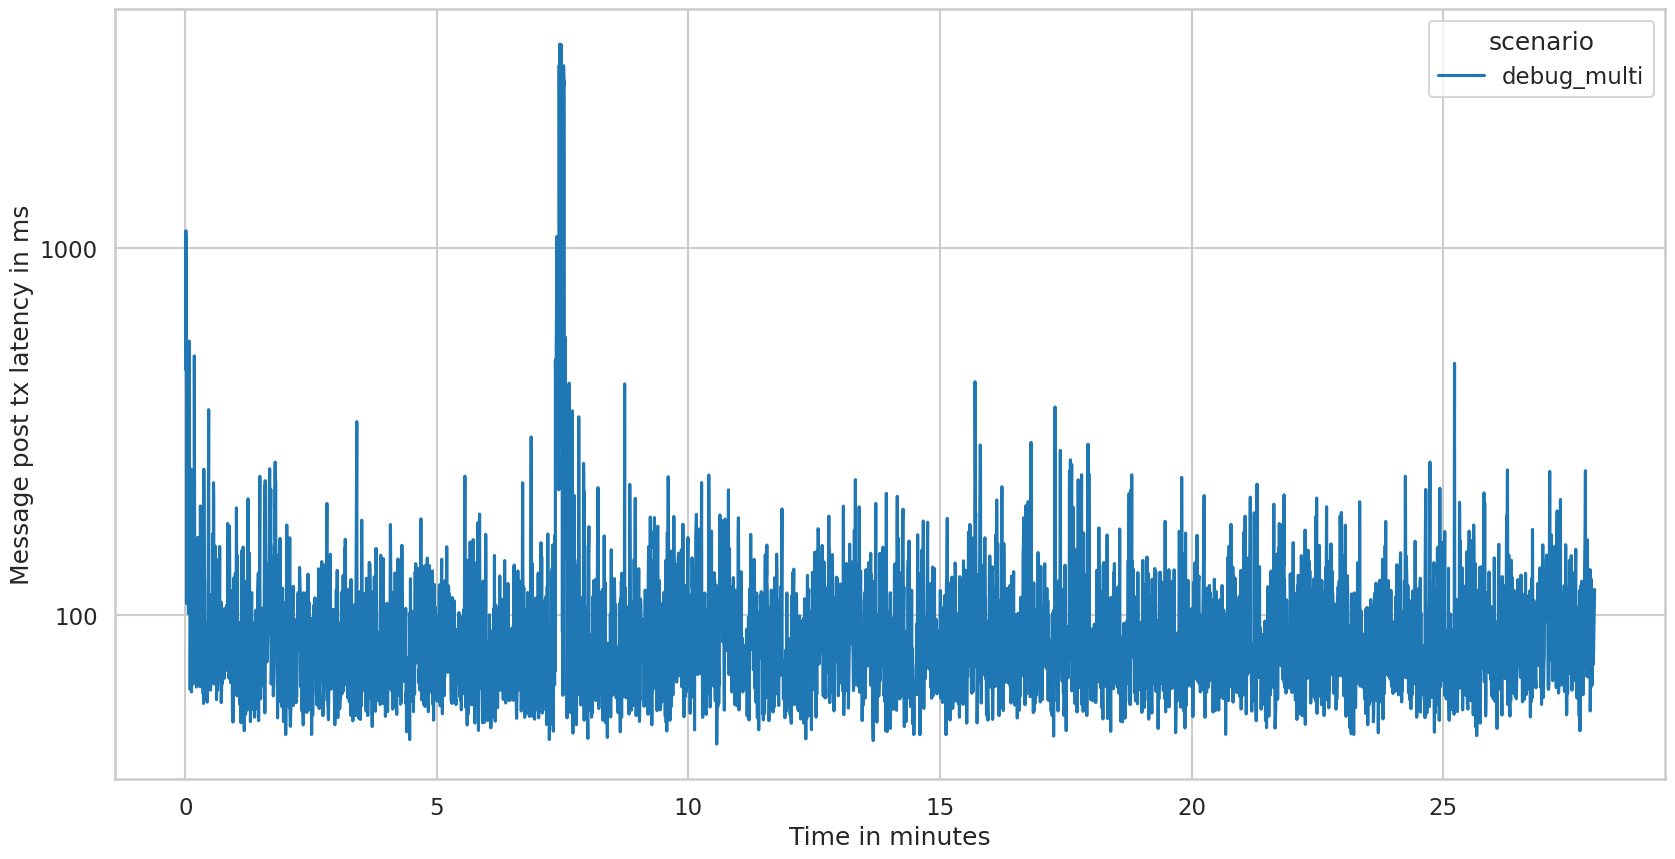

In [45]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in minutes")
ax.set_ylabel("Message post tx latency in ms")
ax.set_yscale("log", base=10)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sb.lineplot(x="time_delta", y=(df["delta_tx"]+df["delta_txack"]), hue="scenario", data=df, ax=ax)

In [ ]:
df = toot

In [8]:
toot.df["timestamp_iso"] = pd.to_datetime(toot.df["timestamp_iso"])
toot.df["message_timestamp"] = pd.to_datetime(toot.df["message_timestamp"])
toot.df["server_timestamp"] = pd.to_datetime(toot.df["server_timestamp"])
toot.df["timestamp_iso"]

169941    2023-02-06 04:05:12.237
169942    2023-02-06 04:05:12.334
169943    2023-02-06 04:05:12.340
169944    2023-02-06 04:05:12.365
169945    2023-02-06 04:05:12.409
                    ...          
1094331   2023-02-06 13:20:43.844
1094332   2023-02-06 13:20:43.953
1094333   2023-02-06 13:20:44.357
1094334   2023-02-06 13:20:44.787
1094335   2023-02-06 13:20:44.901
Name: timestamp_iso, Length: 1094336, dtype: datetime64[ns]

In [9]:
toot.df["message_timestamp"]


169941    2023-02-06 04:05:11.984142973
169942    2023-02-06 04:05:12.154918783
169943    2023-02-06 04:05:12.109889366
169944    2023-02-06 04:05:12.133314715
169945    2023-02-06 04:05:12.409947090
                       ...             
1094331   2023-02-06 13:20:43.844431345
1094332   2023-02-06 13:20:43.952997856
1094333   2023-02-06 13:20:44.357465087
1094334   2023-02-06 13:20:44.787248576
1094335   2023-02-06 13:20:44.901136725
Name: message_timestamp, Length: 1094336, dtype: datetime64[ns]

In [10]:
toot.df["server_timestamp"]


169941    2023-02-06 04:05:12.090000+00:00
169942    2023-02-06 04:05:12.258000+00:00
169943    2023-02-06 04:05:12.261000+00:00
169944    2023-02-06 04:05:12.240000+00:00
169945    2023-02-06 04:05:12.261000+00:00
                        ...               
1094331   2023-02-06 13:16:13.962000+00:00
1094332   2023-02-06 13:16:13.962000+00:00
1094333   2023-02-06 13:16:14.557000+00:00
1094334   2023-02-06 13:16:14.929000+00:00
1094335   2023-02-06 13:17:25.134000+00:00
Name: server_timestamp, Length: 1094336, dtype: datetime64[ns, UTC]

In [11]:
sent = filter.column("message_type", "post")(toot.df)


In [12]:
toot.df.groupby(by=["scenario", "run", "message_type"]).count()

timestamp_iso  sender_username  message_timestamp  \
scenario run message_type                                                      
1x10     1   post                    802              802                802   
             status                 8020             8020               8020   
         2   post                    802              802                802   
             status                 8020             8020               8020   
         3   post                    802              802                802   
             status                 8020             8020               8020   
         4   post                    802              802                802   
             status                 8020             8020               8020   
         5   post                    802              802                802   
             status                 8020             8020               8020   
1x30     1   post                   2380             2380               2380   
             status                31997            31997              31997   
         2   post                   2375             2375               2375   
             status                32149            32149              32149   
         3   post                   2371             2371               2371   
             status                32241            32241              32241   
         4   post                   2375             2375               2375   
             status                32366            32366              32366   
         5   post                   2378             2378               2378   
             status                32288            32288              32288   
2x10     1   post                   1606             1606               1606   
             status                32120            32120              32120   
         2   post                   1609             1609               1609   
             status                32180            32180              32180   
         3   post                   1602             1602               1602   
             status                32040            32040              32040   
         4   post                   1605             1605               1605   
             status                32100            32100              32100   
         5   post                   1599             1599               1599   
             status                32000            32000              32000   
2x15     1   post                   2390             2390               2390   
             status                69842            69842              69842   
         2   post                   2383             2383               2383   
             status                69078            69078              69078   
         3   post                   4773             4773               4773   
             status               137629           137629             137629   
         4   post                   2394             2394               2394   
             status                68911            68911              68911   
         5   post                   2396             2396               2396   
             status                69139            69139              69139   
3x10     1   post                   2402             2402               2402   
             status                48922            48922              48922   
         2   post                   2396             2396               2396   
             status                48801            48801              48801   
         3   post                   2400             2400               2400   
             status                72000            72000              72000   
         4   post                   2407             2407               2407   
             status                49024            49024              49024   
         5   post          

In [13]:
pd.timedelta_range(start='0 seconds', end=str(max(vm.df["time"]))+' seconds', freq="1s")


TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09',
                ...
                '0 days 00:16:29', '0 days 00:16:30', '0 days 00:16:31',
                '0 days 00:16:32', '0 days 00:16:33', '0 days 00:16:34',
                '0 days 00:16:35', '0 days 00:16:36', '0 days 00:16:37',
                '0 days 00:16:38'],
               dtype='timedelta64[ns]', length=999, freq='S')

**Sind die timedeltas von allen stats gleich lang?**


In [14]:

pd.timedelta_range(start='0 seconds', end=str(max(mp.df["time"]))+' seconds', periods=len(mp.df["time"].unique()))


initializing mpstat
initialized. mpstat


TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09',
                ...
                '0 days 00:16:27', '0 days 00:16:28', '0 days 00:16:29',
                '0 days 00:16:30', '0 days 00:16:31', '0 days 00:16:32',
                '0 days 00:16:33', '0 days 00:16:34', '0 days 00:16:35',
                '0 days 00:16:36'],
               dtype='timedelta64[ns]', length=997, freq=None)

In [14]:

pd.timedelta_range(start='0 seconds', end=str(max(dio.df["time"]))+' seconds', periods=len(dio.df["time"].unique()))


initializing iostat-disk
initialized. iostat-disk


TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09',
                ...
                '0 days 00:32:58', '0 days 00:32:59', '0 days 00:33:00',
                '0 days 00:33:01', '0 days 00:33:02', '0 days 00:33:03',
                '0 days 00:33:04', '0 days 00:33:05', '0 days 00:33:06',
                '0 days 00:33:07'],
               dtype='timedelta64[ns]', length=1988, freq=None)

In [16]:

pd.timedelta_range(start='0 seconds', end=str(max(io.df["time"]))+' seconds', periods=len(io.df["time"].unique()))


initializing iostat-cpu
initialized. iostat-cpu


TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09',
                ...
                '0 days 00:16:29', '0 days 00:16:30', '0 days 00:16:31',
                '0 days 00:16:32', '0 days 00:16:33', '0 days 00:16:34',
                '0 days 00:16:35', '0 days 00:16:36', '0 days 00:16:37',
                '0 days 00:16:38'],
               dtype='timedelta64[ns]', length=999, freq=None)

In [8]:

pd.timedelta_range(start='0 seconds', end=str(max(docker.df["time"]))+' seconds', periods=len(docker.df["time"].unique()))


initializing docker-stats
initialized. docker-stats


TimedeltaIndex([          '0 days 00:00:00', '0 days 00:00:00.196940701',
                '0 days 00:00:00.393881403', '0 days 00:00:00.590822104',
                '0 days 00:00:00.787762806', '0 days 00:00:00.984703508',
                '0 days 00:00:01.181644209', '0 days 00:00:01.378584911',
                '0 days 00:00:01.575525612', '0 days 00:00:01.772466314',
                ...
                '0 days 00:33:00.829576837', '0 days 00:33:01.026517539',
                '0 days 00:33:01.223458240', '0 days 00:33:01.420398942',
                '0 days 00:33:01.617339643', '0 days 00:33:01.814280345',
                '0 days 00:33:02.011221047', '0 days 00:33:02.208161748',
                '0 days 00:33:02.405102450', '0 days 00:33:02.602043152'],
               dtype='timedelta64[ns]', length=10068, freq=None)

In [10]:
docker.df.groupby(by=["scenario", "run", "host", "process", "container_id", "name", "timestamp"]).mean()


/tmp/ipykernel_2788276/2239448978.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  docker.df.groupby(by=["scenario", "run", "host", "process", "container_id", "name", "timestamp"]).mean()


cpu_pct  \
scenario    run host    process        container_id name             timestamp               
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09     0.00   
                                                                     1.675737e+09     0.00   
                                                                     1.675737e+09    62.93   
                                                                     1.675737e+09    62.93   
                                                                     1.675737e+09    34.49   
...                                                                                    ...   
                debug-1 docker[68989]: ef8e5f87dcb6 mastodon-redis-1 1.675739e+09     4.12   
                                                                     1.675739e+09     4.12   
                                                                     1.675739e+09     3.79   
                                                                     1.675739e+09     3.79   
                                                                     1.675739e+09     3.79   

                                                                                   mem_usage  \
scenario    run host    process        container_id name             timestamp                 
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09   0.007843   
                                                                     1.675737e+09   0.007843   
                                                                     1.675737e+09   0.029521   
                                                                     1.675737e+09   0.029521   
                                                                     1.675737e+09   0.037314   
...                                                                                      ...   
                debug-1 docker[68989]: ef8e5f87dcb6 mastodon-redis-1 1.675739e+09   0.027490   
                                                                     1.675739e+09   0.027490   
                                                                     1.675739e+09   0.027568   
                                                                     1.675739e+09   0.027568   
                                                                     1.675739e+09   0.027568   

                                                                                   mem_limit  \
scenario    run host    process        container_id name             timestamp                 
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
                                                                     1.675737e+09   0.000007   
...                                                                                      ...   
                debug-1 docker[68989]: ef8e5f87dcb6 mastodon-redis-1 1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   
                                                                     1.675739e+09   0.000007   

                                                                                   mem_pct  \
scenario    run host    process        container_id name             timestamp               
debug_multi 1   debug-0 docker[68701]: 0b764e5d73fc mastodon-mail-1  1.675737e+09     0.10   
                                                                     1.675737e+0

In [11]:
docker.df["timestamp_micro"].map(lambda i: np.float64(f'0.{i}'))

KeyError: 'timestamp_micro'

In [12]:
docker.df["t"] = docker.df["timestamp"] + docker.df["timestamp_micro"].map(lambda i: np.float64(f'0.{i}'))
docker.df["t"]

KeyError: 'timestamp_micro'

In [21]:
docker.t_lowest = docker.df[["scenario", "run", "name", "t"]].groupby(by=["scenario", "run", "name"]).min()
for i, group in docker.df.groupby(by=["scenario", "run", "name"]):
  docker.df.loc[group.index, 'time_micro'] = group["t"] - docker.t_lowest['t'][i]
docker.df["time_micro"]

225234      0.000000
266607      0.067684
266606      0.067684
225235      0.000000
245926      0.038495
             ...    
925368    929.254355
925367    993.254036
925366    993.254036
925370    928.246777
925376    924.253042
Name: time_micro, Length: 925377, dtype: float64

In [22]:
docker.df["time_micro"] = docker.df["t"] - min(docker.df["t"])
docker.df["time_micro"]

225234        0.000000
266607        0.067684
266606        0.067684
225235        0.000000
245926        0.038495
              ...     
925368    33851.296989
925367    33851.296989
925366    33851.296989
925370    33851.296989
925376    33851.296989
Name: time_micro, Length: 925377, dtype: float64

In [13]:
docker.df["time"]

0           0.000000
1           0.000000
42400       0.100969
42399       0.100969
2           0.499254
            ...     
84795    1982.602043
84794    1982.602043
84793    1982.602043
84797    1982.602043
84803    1982.602043
Name: time, Length: 84804, dtype: float64

In [24]:
docker.df.columns


Index(['scenario', 'run', 'timestamp', 'timestamp_micro', 'host', 'process',
       'container_id', 'name', 'cpu_pct', 'mem_usage', 'mem_limit', 'mem_pct',
       'net_input', 'net_output', 'block_input', 'block_output', 'pid', 'time',
       't', 'time_micro'],
      dtype='object')

In [28]:
docker.df["container_name"] = docker.df["name"].map(lambda s: s[:-2])

In [ ]:
docker.df.groupby(by=["scenario", "run", "timestamp", "timestamp_micro",, "container_name", ""])

In [27]:
s = "hello-1"
s[:-2]


'-'

<AxesSubplot: xlabel='Time in seconds', ylabel='mem_pct'>

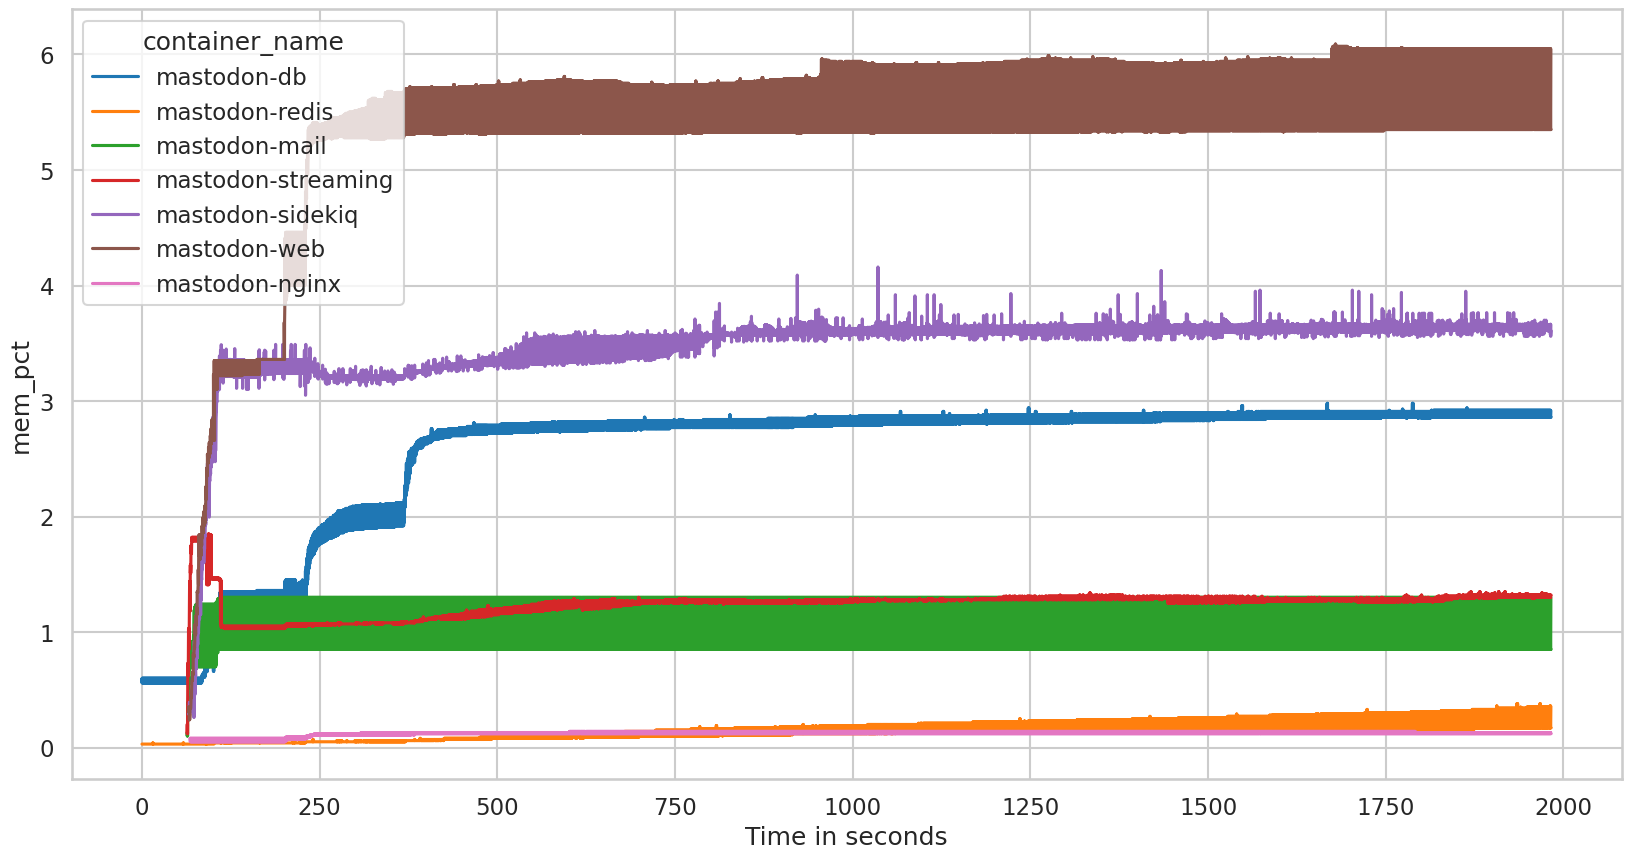

In [16]:
column="mem_pct"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


<AxesSubplot: xlabel='Time in seconds', ylabel='net_input'>

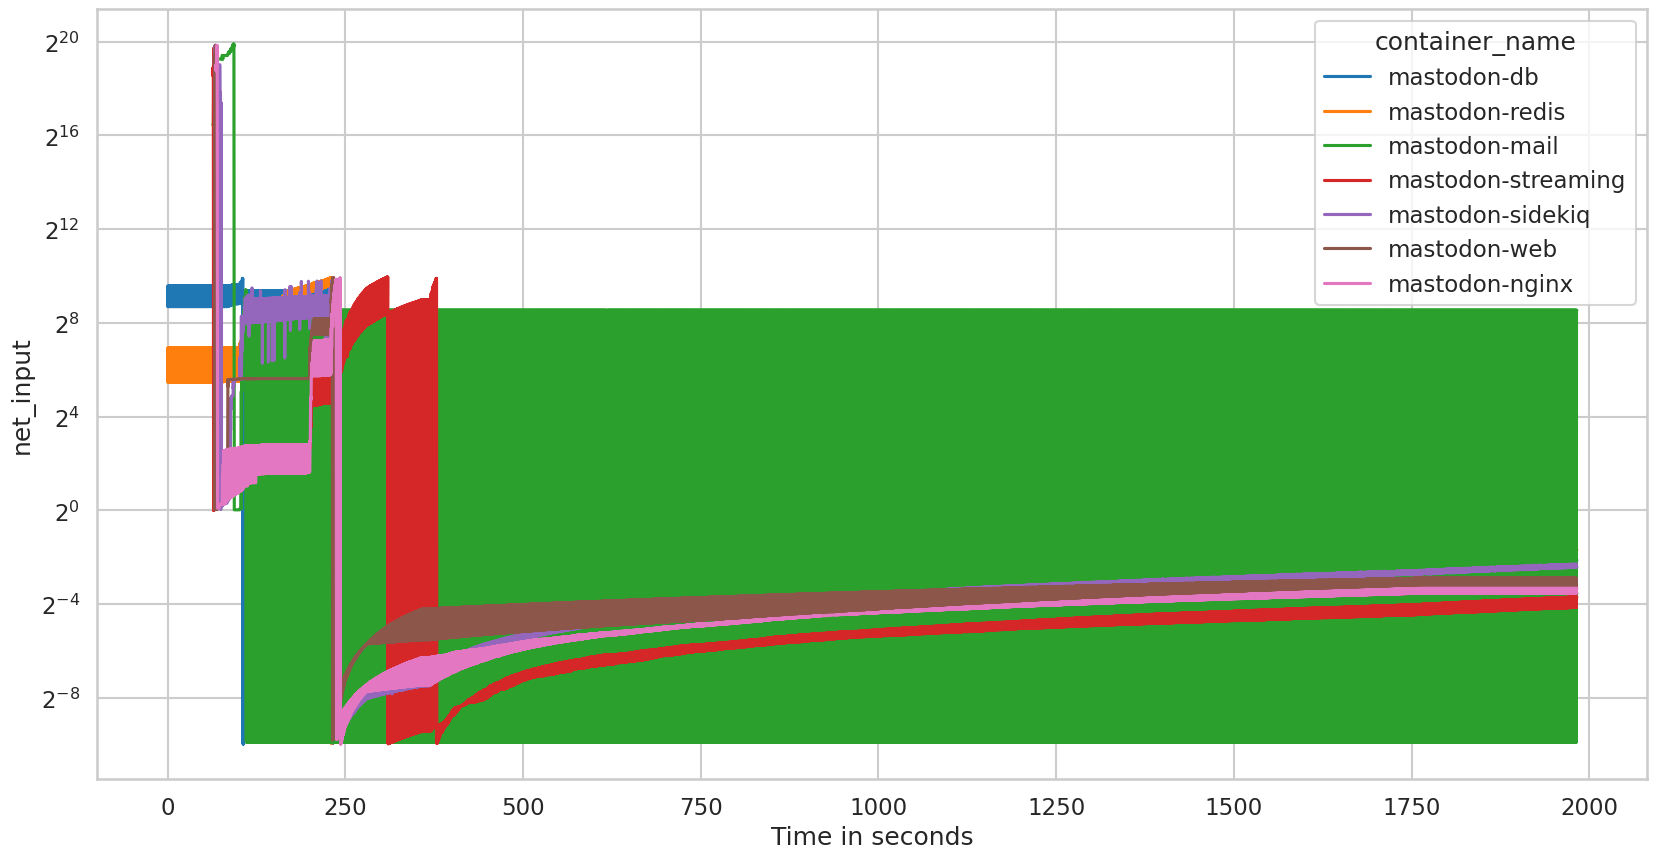

In [23]:
column="net_input"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
ax.set_yscale("log", base=10)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


/home/stendler/Uni/22 WS/cloudservicebenchmarking/mastodon-fediverse-benchmark/analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='Time in seconds', ylabel='net_output'>

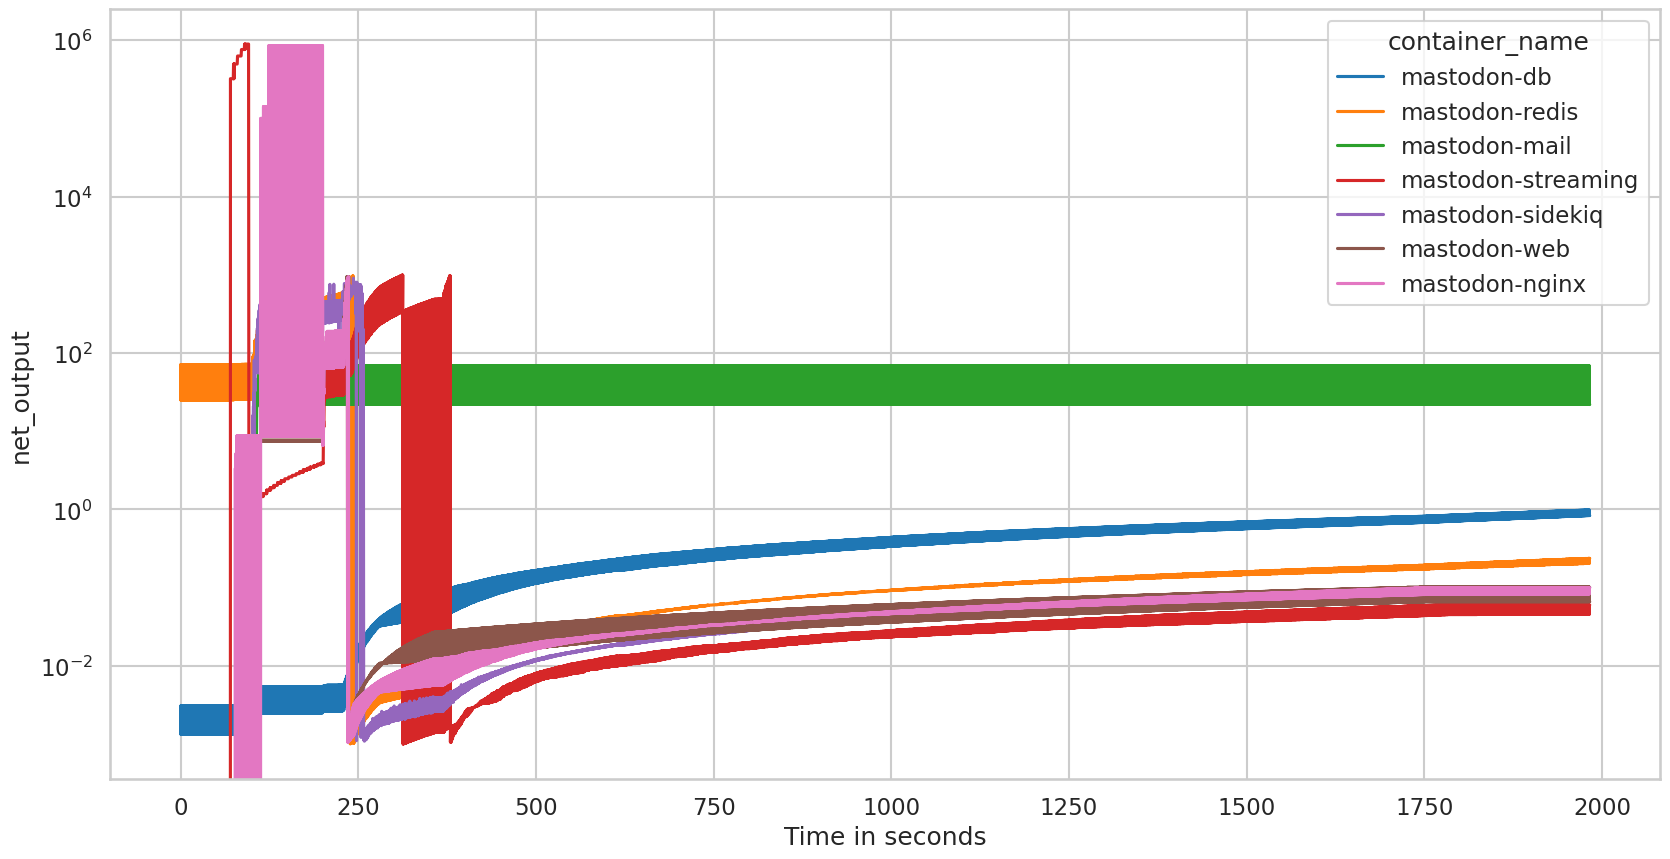

In [22]:
column="net_output"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
ax.set_yscale("log", base=10)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


/home/stendler/Uni/22 WS/cloudservicebenchmarking/mastodon-fediverse-benchmark/analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='Time in seconds', ylabel='block_input'>

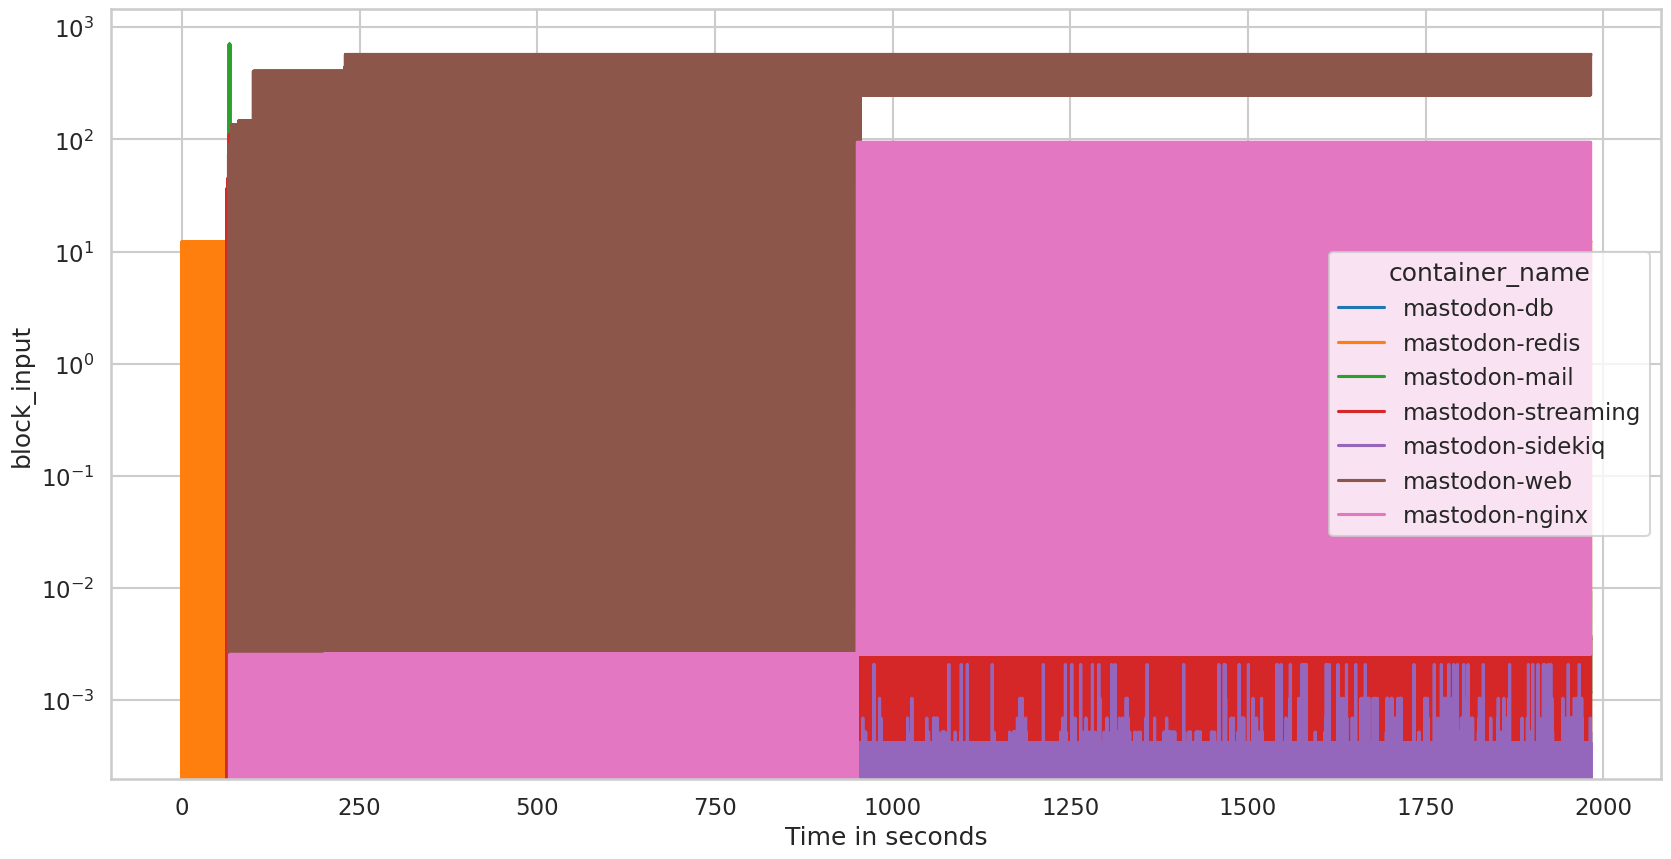

In [24]:
column="block_input"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)
ax.set_yscale("log", base=10)
sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


/home/stendler/Uni/22 WS/cloudservicebenchmarking/mastodon-fediverse-benchmark/analysis/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot: xlabel='Time in seconds', ylabel='block_output'>

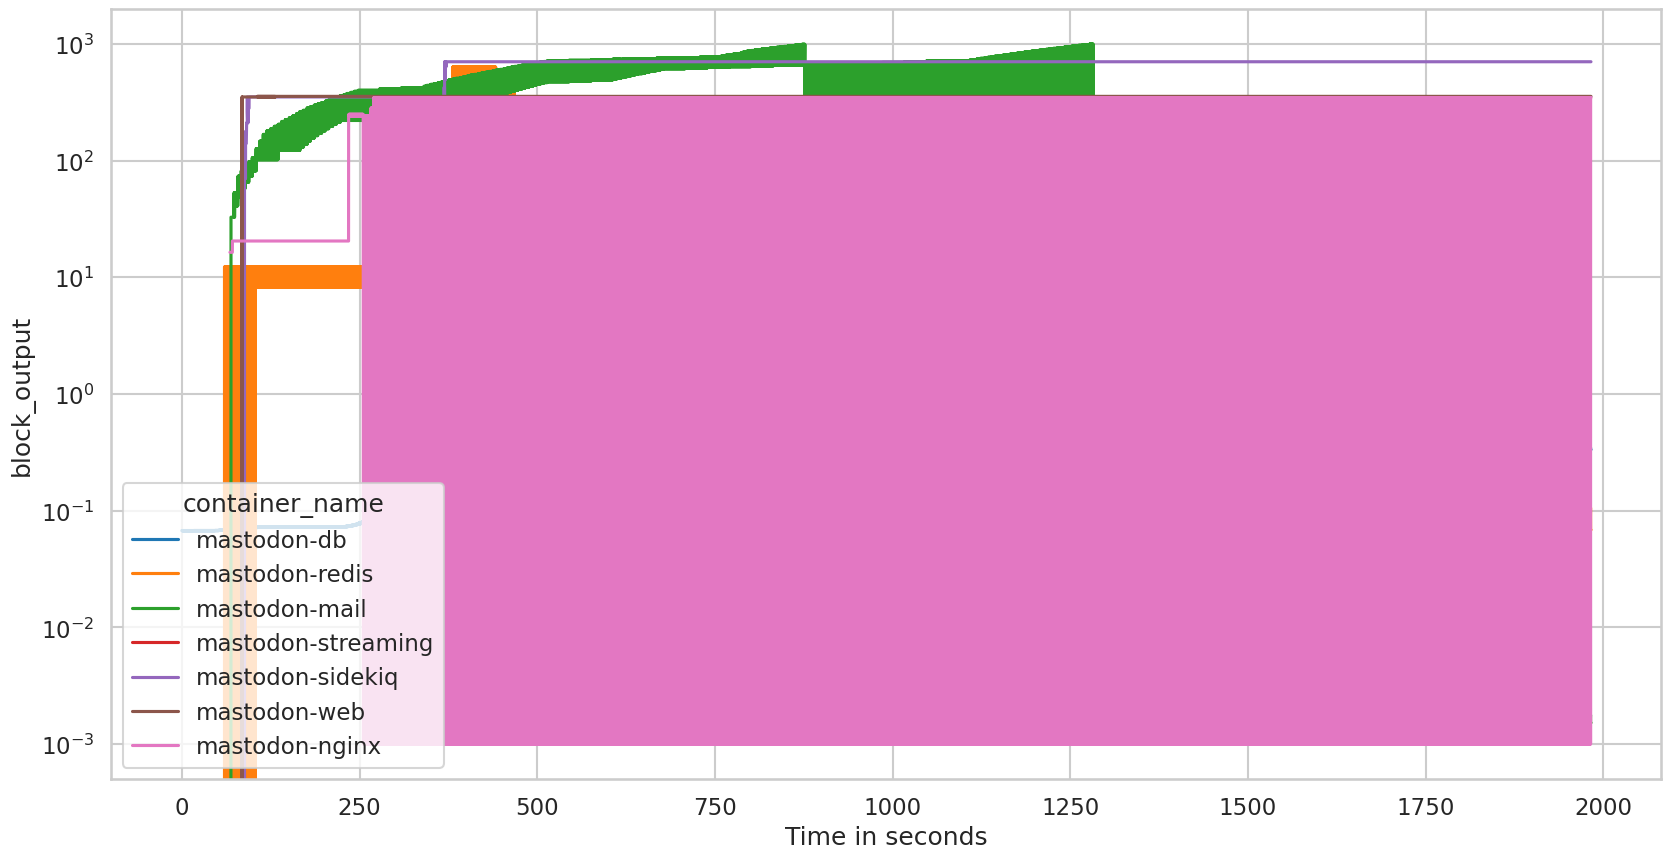

In [25]:
column="block_output"
fig, ax = plt.subplots(figsize=(20, 10), dpi=100)
ax.set_xlabel("Time in seconds")
ax.set_ylabel(column)


sb.lineplot(x="time", y=column, hue="container_name", data=docker.df_container, ax=ax)


In [31]:
docker.df_container


pandas.core.frame.DataFrame

IsADirectoryError: [Errno 21] Is a directory: 'input/2023-02-07T03:03:10'